# Proof of Concept: Linking Climate Data with CFD Prices for Agricultural Commodities

**Objective:** Evaluate the feasibility of predicting CFD price movements (e.g., cotton) by incorporating monthly (or daily aggregated) climatic data over the last 20 years. This notebook serves as a preliminary investigation using machine learning techniques and exploratory data analysis.

**Outline:**
1. Data Acquisition and Loading
2. Data Preprocessing and Aggregation
3. Exploratory Data Analysis (EDA)
4. Feature Engineering (including creation of climatic indices and lag variables)
5. Modeling: Training a simple ML model (e.g., RandomForest)
6. Model Evaluation and Interpretation
7. Conclusions and Next Steps


## 1. Importing Libraries
Import necessary libraries for data analysis, visualization, and modeling.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# You can add more libraries as needed

%matplotlib inline

## 2. Data Acquisition and Loading
Load the climate and CFD price data. For this PoC, you can use synthetic datasets or CSV samples.

*Example files:*
- `climate_data.csv`: Daily or monthly climate variables (temperature, precipitation, extreme events, etc.)
- `price_data.csv`: Historical CFD price series (e.g., cotton) on a monthly basis

In [4]:
import xarray as xr
ds=xr.open_dataset("/Users/charly_1/Downloads/22491997/CROPGRIDSv1.08_NC_maps/CROPGRIDSv1.08_cocoa.nc")

ValueError: No matching item found for the query 'naturalearth_lowres'.

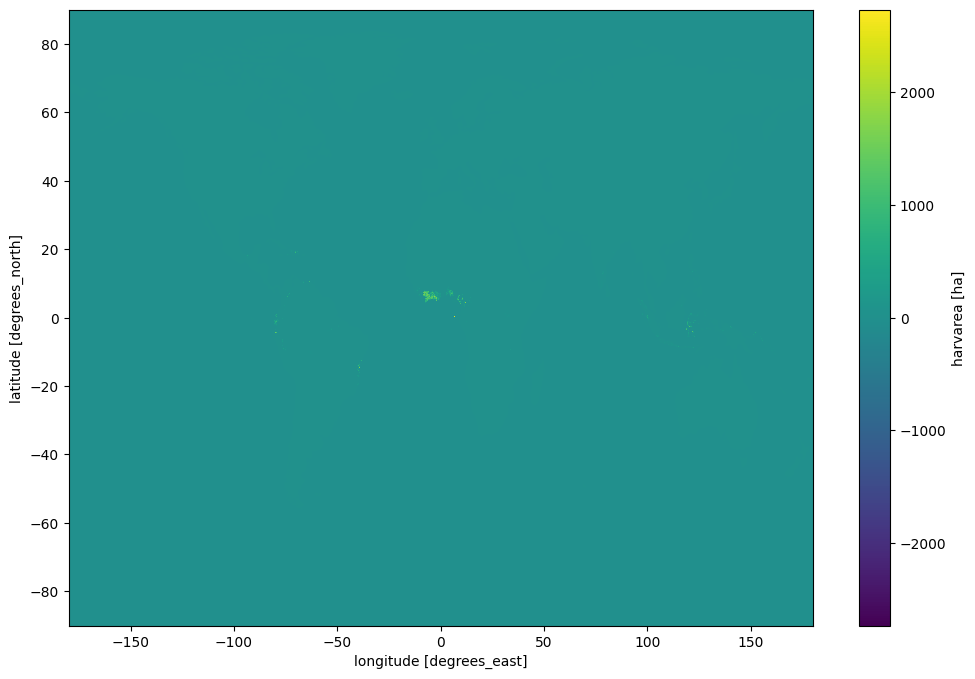

In [ ]:
import geopandas as gpd
from geodatasets import get_path

ax = ds["harvarea"].plot(figsize=(12, 8), cmap='viridis')
world = gpd.read_file(get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title("Harvarea overlayed on World Countries")
plt.show()


In [3]:
import requests
import geopandas as gpd
from pathlib import Path

# URL del GeoJSON de límites administrativos
url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/world-administrative-boundaries/exports/geojson?lang=en&timezone=Europe%2FBerlin"

# Definir el directorio de salida y el nombre del archivo
output_dir = Path("data_inputs")
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / "world-administrative-boundaries.geojson"

# Descargar el GeoJSON
response = requests.get(url)
if response.status_code == 200:
    with open(output_file, "wb") as f:
        f.write(response.content)
    print(f"GeoJSON downloaded successfully and saved to {output_file}")
else:
    print("Error downloading file:", response.status_code)

# Cargar el archivo en un GeoDataFrame
gdf = gpd.read_file(output_file)
print(f"GeoDataFrame loaded successfully with {len(gdf)} records.")

GeoJSON downloaded successfully and saved to data_inputs/world-administrative-boundaries.geojson
GeoDataFrame loaded successfully with 256 records.


In [ ]:
import requests
import geopandas as gpd
from pathlib import Path
import cdsapi
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configuración básica del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Ruta del GeoJSON de límites administrativos
shapefile_path = Path("data_inputs/shapefile/world-administrative-boundaries.geojson")

# Cargar el GeoJSON en un GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# Filtrar los países principales productores de cacao
countries_of_interest = ["Ghana", "Côte d'Ivoire", "Nigeria", "Cameroon"]
gdf_filtered = gdf[gdf["name"].isin(countries_of_interest)]

# Calcular los límites totales para cada país en el formato [North, West, South, East]
country_bounds = {}
for country in countries_of_interest:
    country_gdf = gdf_filtered[gdf_filtered["name"] == country]
    minx, miny, maxx, maxy = country_gdf.total_bounds
    # Formato requerido por CDS API: [North, West, South, East]
    area = [maxy, minx, miny, maxx]
    country_bounds[country] = area
    logger.info(f"{country} - Área: {area}")

# Crear el cliente CDS API (asegúrate de tener configurado el archivo ~/.cdsapirc con tus credenciales)
client = cdsapi.Client()

# Parámetros comunes para la solicitud
dataset = "derived-era5-single-levels-daily-statistics"
year = "2020"
# Usamos todos los meses (agrupando por mes)
months = [f"{i:02d}" for i in range(1, 13)]
# Lista de días: se incluye del 1 al 31 para que el dataset incluya todos los días del mes
days_list = [f"{i:02d}" for i in range(1, 32)]

# Directorio de salida para guardar los archivos descargados
output_dir = Path("data_inputs/climate_data")
output_dir.mkdir(parents=True, exist_ok=True)

def download_monthly_data(country, variable, daily_stat, area, month):
    """
    Descarga datos climáticos para un país, una variable y un mes específico.
    Se genera un archivo que contiene la información diaria del mes.
    """
    request = {
        "product_type": "reanalysis",
        "variable": [variable],
        "year": year,
        "month": [month],
        "day": days_list,  # Todos los días del mes
        "daily_statistic": daily_stat,
        "time_zone": "utc+00:00",
        "frequency": "1_hourly",
        "area": area
    }
    output_file = output_dir / f"era5_land_{variable}_{year}_{country}_M{month}.nc"
    logger.info(f"Descargando {variable} para {country} - Mes: {month} en {output_file}...")
    client.retrieve(dataset, request).download(str(output_file))
    logger.info(f"Descarga completada para {variable} en {country} - Mes: {month}.")

# Lista de variables y sus correspondientes estadísticos
variables_info = [
    {"variable": "2m_temperature", "daily_statistic": "daily_maximum"},
    {"variable": "total_precipitation", "daily_statistic": "daily_sum"}
]

# Usar ThreadPoolExecutor para paralelizar las descargas de forma granular (por país, mes y variable)
# Ajustamos max_workers a un número moderado para reducir el riesgo de errores 429.
max_workers = 4
tasks = []

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    for country, area in country_bounds.items():
        for month in months:
            for info in variables_info:
                tasks.append(executor.submit(
                    download_monthly_data,
                    country,
                    info["variable"],
                    info["daily_statistic"],
                    area,
                    month
                ))
    for future in as_completed(tasks):
        try:
            future.result()
        except Exception as e:
            logger.error(f"Error en una tarea de descarga: {e}")

INFO:__main__:Ghana - Área: [np.float64(11.15569000000005), np.float64(-3.2488899999999603), np.float64(4.727080000000058), np.float64(1.2027800000000752)]
INFO:__main__:Côte d'Ivoire - Área: [np.float64(10.73526000000004), np.float64(-8.606379999999945), np.float64(4.344720000000052), np.float64(-2.4877799999999297)]
INFO:__main__:Nigeria - Área: [np.float64(13.891500000000065), np.float64(2.6925000000000523), np.float64(4.272850000000062), np.float64(14.649650000000065)]
INFO:__main__:Cameroon - Área: [np.float64(13.085000000000036), np.float64(8.502360000000067), np.float64(1.6541700000000787), np.float64(16.20700000000005)]
2025-03-09 16:23:10,714 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-09 16:23:10,715 WARNING [2024-06-16T00:00:00] CDS API syntax 

In [30]:
import os

directory = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs"

for root, dirs, files in os.walk(directory):
    for file in files:
        print(os.path.join(root, file))

/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/.DS_Store
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/shapefile/world-administrative-boundaries.geojson
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_sugarnes.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_vegfor.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_currant.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_areca.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_sisal.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_hazelnut.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_sorghumfor.nc
/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_oats.nc
/Users/charly_1/Documents/GitHub/crop_analysis/da

In [34]:
import os
import glob
import xarray as xr
import numpy as np
import shutil

# Define the climate data directory
climate_folder = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/climate_data"

# Find all NetCDF files in the climate_data folder
all_files = glob.glob(os.path.join(climate_folder, "*.nc"))
print(f"Found {len(all_files)} climate files.")

# Separate files based on variable type using keywords in the filename
temp_files = [f for f in all_files if "2m_temperature" in f]
prec_files = [f for f in all_files if "total_precipitation" in f]
print(f"Found {len(temp_files)} temperature files and {len(prec_files)} precipitation files.")

# Function to load a dataset, rename coordinates, and sort them
def load_dataset(file):
    ds = xr.open_dataset(file)
    ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    ds = ds.sortby("lat").sortby("lon")
    # Optionally, drop the 'history' attribute to avoid conflicts
    ds.attrs.pop("history", None)
    return ds

# Compute global bounding box from all climate files
lat_min_list, lat_max_list, lon_min_list, lon_max_list = [], [], [], []
for f in temp_files + prec_files:
    ds = load_dataset(f)
    lat_min_list.append(ds.lat.min().item())
    lat_max_list.append(ds.lat.max().item())
    lon_min_list.append(ds.lon.min().item())
    lon_max_list.append(ds.lon.max().item())

global_lat_min = min(lat_min_list)
global_lat_max = max(lat_max_list)
global_lon_min = min(lon_min_list)
global_lon_max = max(lon_max_list)
print(f"Global bounds: lat [{global_lat_min}, {global_lat_max}], lon [{global_lon_min}, {global_lon_max}]")

# Determine resolution from the first temperature file (assuming similar resolution among files)
example_ds = load_dataset(temp_files[0])
lat_res = (example_ds.lat.max() - example_ds.lat.min()) / (len(example_ds.lat) - 1)
lon_res = (example_ds.lon.max() - example_ds.lon.min()) / (len(example_ds.lon) - 1)
print(f"Using resolution: lat_res = {lat_res}, lon_res = {lon_res}")

# Create a common grid spanning the global bounds
lat_new = np.arange(global_lat_min, global_lat_max + lat_res, lat_res)
lon_new = np.arange(global_lon_min, global_lon_max + lon_res, lon_res)
print(f"Common grid: {len(lat_new)} lat points and {len(lon_new)} lon points.")

# Function to regrid a dataset onto the common grid using interpolation
def regrid_dataset(ds):
    return ds.interp(lat=lat_new, lon=lon_new)

# Regrid all temperature and precipitation datasets
temp_datasets = [regrid_dataset(load_dataset(f)) for f in temp_files]
prec_datasets = [regrid_dataset(load_dataset(f)) for f in prec_files]

# Combine regridded datasets using outer join and drop conflicting attributes to handle metadata differences
ds_temp = xr.combine_by_coords(temp_datasets, join="outer", combine_attrs="drop_conflicts")
ds_prec = xr.combine_by_coords(prec_datasets, join="outer", combine_attrs="drop_conflicts")

# Merge the two groups (they now share the same coordinate grid)
ds_climate = xr.merge([ds_temp, ds_prec], combine_attrs="drop_conflicts")
print("Merged climate dataset structure:")
print(ds_climate)
print("=" * 40)

# Optionally, write the merged dataset to a Zarr store for efficient access later
zarr_store = "/Users/charly_1/Documents/GitHub/crop_analysis/aggregated_climate_data.zarr"
if os.path.exists(zarr_store):
    shutil.rmtree(zarr_store)  # Remove the existing store if it exists

ds_climate.to_zarr(zarr_store, mode="w")
print(f"Aggregated climate dataset successfully saved to Zarr store at: {zarr_store}")

Found 96 climate files.
Found 48 temperature files and 48 precipitation files.
Global bounds: lat [1.654, 13.773], lon [-8.607, 16.003]
Using resolution: lat_res = <xarray.DataArray 'lat' ()> Size: 8B
array(0.25004)
Coordinates:
    number   int64 8B 0, lon_res = <xarray.DataArray 'lon' ()> Size: 8B
array(0.25004167)
Coordinates:
    number   int64 8B 0
Common grid: 50 lat points and 100 lon points.
Merged climate dataset structure:
<xarray.Dataset> Size: 29MB
Dimensions:     (valid_time: 366, lat: 50, lon: 100)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * lat         (lat) float64 400B 1.654 1.904 2.154 2.404 ... 13.41 13.66 13.91
  * lon         (lon) float64 800B -8.607 -8.357 -8.107 ... 15.65 15.9 16.15
Data variables:
    t2m         (valid_time, lat, lon) float64 15MB nan nan nan ... nan nan nan
    tp          (valid_time, lat, lon) float64 15MB nan nan nan ... nan nan nan
Attributes:
    GRIB_centre:      

/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


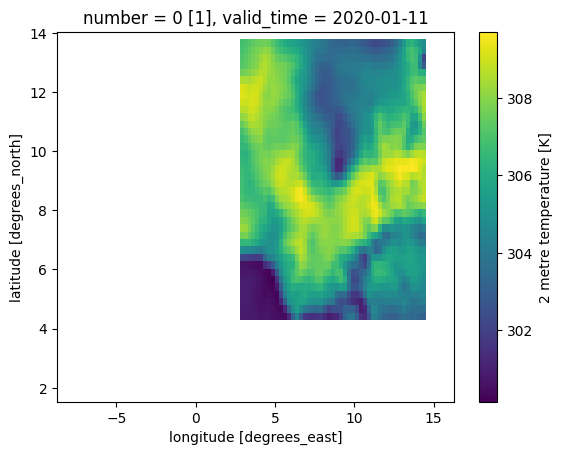

In [40]:
import xarray as xr
ds=xr.open_zarr(r"/Users/charly_1/Documents/GitHub/crop_analysis/data_zarr/era5_land_all_2020.zarr")
ds.t2m.isel(valid_time=10).plot()

NameError: name 'plt' is not defined

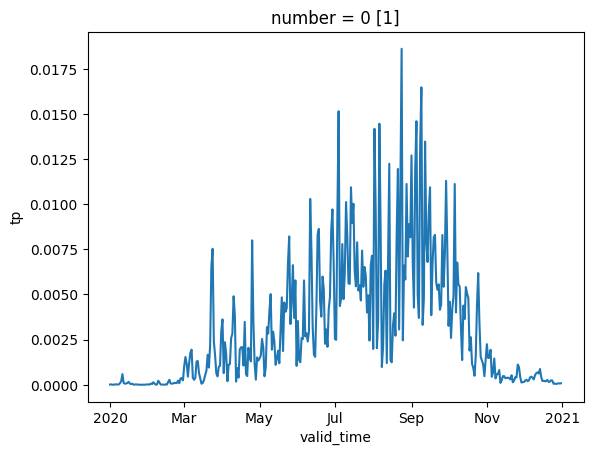

In [27]:
combined_ds.tp.mean(dim=['latitude', 'longitude']).plot()
plt.xlabel('Fecha')
plt.ylabel('Precipitación Promedio')
plt.title('Precipitación Promedio Diaria 2020')
plt.show()

# Vulnerability Function for Cocoa Yield Loss

This section implements a vulnerability function that estimates the percentage yield loss for cocoa based on daily maximum temperature and monthly precipitation. The function is defined as follows:

\[
L(T, P) = 100 \times \left(1 - \exp\left[-\alpha \cdot \max(0, T - T_{\text{opt}})\right]\right) + \beta \cdot \max(0, P_{\text{th}} - P)
\]

where:
- \(T\) is the daily maximum temperature in degrees Celsius.
- \(T_{\text{opt}}\) is the optimum temperature for cocoa (assumed here as 24 °C).
- \(\alpha\) is the temperature sensitivity coefficient (default value 0.11).
- \(P\) is the monthly precipitation in mm.
- \(P_{\text{th}}\) is the critical precipitation threshold (assumed 100 mm).
- \(\beta\) is the precipitation deficit coefficient (default value 0.0075 per mm).

This function is inspired by quantitative approaches found in the literature, such as the studies by [Schroth et al., 2016](http://dx.doi.org/10.1016/j.scitotenv.2016.03.024) and [Läderach et al., 2013](http://dx.doi.org/10.1007/s10584-013-0774-8), which relate climate hazards (e.g., excessive temperature and rainfall deficits) to changes in the climatic suitability for cocoa. In our formulation, the yield loss increases exponentially when the temperature exceeds the optimum and linearly when precipitation falls below the threshold.

Below is the Python code that defines and demonstrates the usage of this vulnerability function.

In [41]:
import numpy as np

def vulnerability_loss(T, P, T_opt=24.0+273.15, P_th=100.0, alpha=0.11, beta=0.0075):
    """
    Compute the estimated yield loss percentage for cocoa based on daily maximum temperature (T)
    and monthly total precipitation (P). Temperature is expected in Kelvin.
    
    Parameters:
    - T (float): Daily maximum temperature in Kelvin.
    - P (float): Monthly total precipitation (mm).
    - T_opt (float): Optimum temperature for cocoa (default is 24°C in Kelvin, i.e., 297.15 K).
    - P_th (float): Critical precipitation threshold (default 100 mm).
    - alpha (float): Temperature sensitivity coefficient (default 0.11).
    - beta (float): Precipitation deficit coefficient (default 0.0075 per mm deficit).
    
    Returns:
    - float: Estimated yield loss percentage.
    
    The function is defined as:
    
    L(T, P) = 100 * (1 - exp[-alpha * max(0, T - T_opt)]) + beta * max(0, P_th - P)
    """
    temp_excess = max(0, T - T_opt)
    temp_effect = 100 * (1 - np.exp(-alpha * temp_excess))
    precip_deficit = max(0, P_th - P)
    precip_effect = beta * precip_deficit
    return temp_effect + precip_effect

# Example usage:
# Temperature example: 26°C converted to Kelvin (26 + 273.15 = 299.15 K)
T_example = 26 + 273.15  
# Monthly precipitation example: 80 mm (20 mm below the 100 mm threshold)
P_example = 80  
loss_percentage = vulnerability_loss(T_example, P_example)
print(f"Estimated yield loss percentage: {loss_percentage:.2f}%")

Estimated yield loss percentage: 19.90%


In [42]:

import xarray as xr
import numpy as np

# Assuming vulnerability_loss function is defined as in our previous code snippet.
def vulnerability_loss(T, P, T_opt=24.0+273.15, P_th=100.0, alpha=0.11, beta=0.0075):
    """
    Compute the estimated yield loss percentage for cocoa based on daily maximum temperature (in Kelvin)
    and monthly total precipitation (mm).
    """
    temp_excess = np.maximum(0, T - T_opt)
    temp_effect = 100 * (1 - np.exp(-alpha * temp_excess))
    precip_deficit = np.maximum(0, P_th - P)
    precip_effect = beta * precip_deficit
    return temp_effect + precip_effect

# Open the aggregated climate Zarr store
zarr_store = "/Users/charly_1/Documents/GitHub/crop_analysis/aggregated_climate_data.zarr"
ds = xr.open_zarr(zarr_store)

# Check variable names (assume temperature is 't2m' and precipitation is 'tp')
print(ds)

# --- Temporal Aggregation if Needed ---
# If ds.t2m is daily and ds.tp is daily, but you need monthly precipitation:
# For example, group by month for precipitation:
ds_monthly_tp = ds.tp.resample(valid_time="1M").sum()  # monthly total precipitation
# For temperature, if you need the daily maximum, assume ds.t2m already is daily max,
# or resample if needed:
# ds_daily_t2m = ds.t2m.resample(valid_time="1D").max()

# --- Align Datasets ---
# We assume that the regridding already produced a common spatial grid.
# For temporal alignment, you may need to match the time coordinates.
# Here, we'll assume ds.t2m (daily) and ds_monthly_tp (monthly) need to be combined.
# One approach is to apply the vulnerability function on a per-month basis.

# Example: Compute vulnerability for each month.
# This snippet loops over each month, applying the function on the daily maximum temperature and the monthly precipitation total.
vulnerability_list = []
for month, t2m_month in ds.t2m.groupby("valid_time.month"):
    # Get the corresponding monthly precipitation value (broadcast to the daily t2m shape)
    # Here we assume one precipitation value per month per grid point.
    tp_month = ds_monthly_tp.sel(valid_time=ds_monthly_tp.valid_time.dt.month == month)
    
    # If tp_month has one time value per month, expand dims to match t2m_month along the time dimension.
    # Note: Adjust this step based on the actual shape of your data.
    tp_broadcast = tp_month.squeeze("valid_time")
    
    # Apply the function elementwise using apply_ufunc.
    # Here, vectorize=True makes the function apply elementwise.
    loss = xr.apply_ufunc(
        vulnerability_loss,
        t2m_month, tp_broadcast,
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
    )
    # Assign the month coordinate for later concatenation
    loss = loss.assign_coords(valid_time=t2m_month.valid_time)
    vulnerability_list.append(loss)

# Combine the monthly results back along the time dimension
vulnerability_da = xr.concat(vulnerability_list, dim="valid_time")

# Add the vulnerability data array to the dataset
ds = ds.assign(vulnerability=vulnerability_da)

print(ds)

<xarray.Dataset> Size: 29MB
Dimensions:     (valid_time: 366, lat: 50, lon: 100)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
    number      int64 8B ...
  * lat         (lat) float64 400B 1.654 1.904 2.154 2.404 ... 13.41 13.66 13.91
  * lon         (lon) float64 800B -8.607 -8.357 -8.107 ... 15.65 15.9 16.15
Data variables:
    t2m         (valid_time, lat, lon) float64 15MB dask.array<chunksize=(92, 13, 50), meta=np.ndarray>
    tp          (valid_time, lat, lon) float64 15MB dask.array<chunksize=(92, 13, 50), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
<xarray.Dataset> Size: 44MB
Dimensions:        (valid_time: 366, lat: 50, lon: 100)
Coordinates:
  * valid_time     (valid_time) datetime64[ns] 3kB 

/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


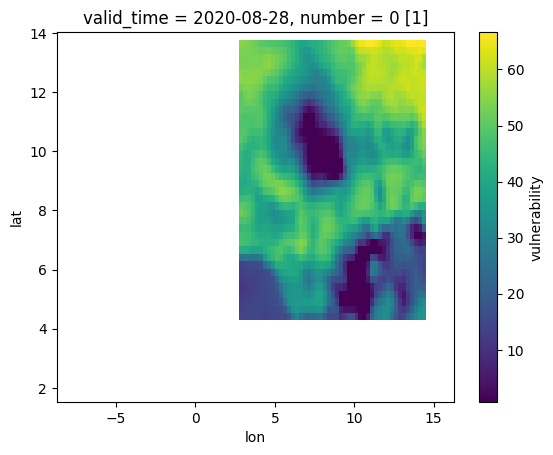

In [47]:
ds.vulnerability.isel(valid_time=240).plot()

## 3. Data Preprocessing and Aggregation
Convert the date columns to datetime (if not already done), handle missing values and outliers, aggregate daily data into monthly metrics (e.g., averages, sums, or counts of extreme events), and merge both datasets using the `date` column.

In [ ]:
# Example: Aggregating daily climate data to monthly data
climate_monthly = climate_df.resample('M', on='date').agg({
    'temperature': 'mean',
    'precipitation': 'sum',
    # Assuming 'hail' is a binary indicator, count the number of days with hail events
    'hail': 'sum'
}).reset_index()

# Merge climate and price data
data = pd.merge(price_df, climate_monthly, on='date', how='inner')

## 4. Exploratory Data Analysis (EDA)
Visualize the time series, examine variable distributions, and compute a correlation matrix to identify preliminary relationships.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['price'], label='CFD Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('CFD Price Over Time')
plt.legend()
plt.show()

# Calculate and print the correlation matrix
corr_matrix = data.corr()
print(corr_matrix)

## 5. Feature Engineering
Create new features such as drought indices, counts of extreme events, or lag variables. For example, create a one-month lag for precipitation.

In [ ]:
data['precipitation_lag1'] = data['precipitation'].shift(1)
# Remove rows with NA values resulting from the shift
data = data.dropna()

## 6. Modeling: Training a Simple Machine Learning Model
Use a simple model (e.g., RandomForest) to predict the CFD price using the climate variables as predictors.

In [ ]:
# Define features and target
features = ['temperature', 'precipitation', 'hail', 'precipitation_lag1']
target = 'price'

# Use TimeSeriesSplit for temporal cross-validation
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]
    
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}')

## 7. Model Evaluation and Interpretation
Visualize the predictions versus the actual values and analyze feature importance to understand the impact of each climate variable.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], y_test, label='Actual Price')
plt.plot(test_data['date'], predictions, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted CFD Prices')
plt.legend()
plt.show()

# Display feature importances
importances = model.feature_importances_
for feat, imp in zip(features, importances):
    print(f'{feat}: {imp:.2f}')

## 8. Conclusion and Next Steps
Summarize your findings and the model's predictive capability. Discuss limitations and potential improvements (e.g., incorporating more climatic variables, using hybrid models or LSTM networks). Outline the next steps to transition this PoC into a production-level model, such as integrating streaming data and continuously updating the model.

# End of Notebook

This PoC serves as a starting point to evaluate whether incorporating climate data can improve the prediction of agricultural CFD prices. Further research and model refinement will be necessary to address challenges such as data granularity, external economic factors, and model adaptability over time.